## Dataset and Problem Introduction

In this analysis, we write a program that checks if two strings sound the same using fuzzy name matching (as opposed to spelling).

<p>The datasets examined includes a list of best-selling book authors, and a database of names and genders to identify the gender of each author.</p>

<b>Data Sources:</b> 
* https://www.kaggle.com/amritvirsinghx/gender-prediction-from-name-pronunciation
* https://www.ssa.gov/oact/babynames/limits.html

<br>Reference: https://www.datacamp.com/

In [25]:
# Importing the fuzzy package
import fuzzy

# Exploring the output of fuzzy.nysiis
fuzzy.nysiis('tufool')

# Testing equivalence of similar sounding words
fuzzy.nysiis('tomorrow') == fuzzy.nysiis('tommorow')

True

## Authors
<p>The New York Times puts out a weekly list of best-selling books from different genres, and which has been published since the 1930’s.  We’ll focus on Children’s Picture Books, and analyze the gender distribution of authors to see if there have been changes over time. We'll begin by reading in the data on the best-selling authors from 2008 to 2017.</p>

In [26]:
# Importing the pandas module
import pandas as pd

# Reading in datasets/nytkids_yearly.csv, which is semicolon delimited.
author_df = pd.read_csv('datasets/nytkids_yearly.csv', delimiter=';')

# Looping through author_df['Author'] to extract the authors first names
first_name = []
for name in author_df['Author']:
    first_name.append(name.split()[0])

# Adding first_name as a column to author_df
author_df['first_name'] = first_name

# Checking out the first few rows of author_df
author_df.head()

,Year,Book Title,Author,Besteller this year,first_name
0,2017,DRAGONS LOVE TACOS,Adam Rubin,49,Adam
1,2017,THE WONDERFUL THINGS YOU WILL BE,Emily Winfield Martin,48,Emily
2,2017,THE DAY THE CRAYONS QUIT,Drew Daywalt,44,Drew
3,2017,"ROSIE REVERE, ENGINEER",Andrea Beaty,38,Andrea
4,2017,"ADA TWIST, SCIENTIST",Andrea Beaty,28,Andrea


## Phonics
<p>We now create a new column that contains the phonetic equivalent of every first name that we just extracted. </p>
<p>To ensure we have made no mistake, we compare the number of unique values in the <code>first_name</code> column and the number of unique values in the nysiis coded column. The number of unique nysiis first names should be less than or equal to the number of actual first names.</p>

In [27]:
# Importing numpy
import numpy as np

# Looping through author's first names to create the nysiis (fuzzy) equivalent
nysiis_name = []
for firstname in author_df['first_name']:
    nysiis_name.append(fuzzy.nysiis(firstname))

# Adding nysiis_name as a column to author_df
author_df['nysiis_name'] = nysiis_name

# Printing out the difference between unique firstnames and unique nysiis_names:
diff_names = len(np.unique(author_df.first_name)) - \
    len(np.unique(author_df.nysiis_name))
print('There are ' + str(diff_names) +
      ' more unqiue values for first_name than nysiis_name')

There are 25 more unqiue values for first_name than nysiis_name


## Names and Gender
<p>We now use <code>babynames_nysiis.csv</code>, a dataset that is derived from the Social Security Administration’s baby name data, to identify author genders. The dataset contains unique NYSIIS versions of baby names, and also includes the percentage of times the name appeared as a female name (<code>perc_female</code>) and the percentage of times it appeared as a male name (<code>perc_male</code>). </p>
<p>We'll use this data to create a list of <code>gender</code>. We make the following simplifying assumptions for this analysis: For each name, if <code>perc_female</code> is greater than <code>perc_male</code> then assume the name is female, if <code>perc_female</code> is less than <code>perc_male</code> then assume it is a male name, and if the percentages are equal then it's a "neutral" name.</p>

In [30]:
# Reading in datasets/babynames_nysiis.csv, which is semicolon delimited.
babies_df = pd.read_csv('datasets/babynames_nysiis.csv', delimiter=';')

# Looping through the rows of babies_df to and filling up gender
gender = []
for idx in range(len(babies_df['babynysiis'])):
    if babies_df.perc_female[idx] > babies_df.perc_male[idx]:
        gender.append('Female')
    elif babies_df.perc_female[idx] < babies_df.perc_male[idx]:
        gender.append('Male')
    else:
        gender.append('Neutral')

# Adding a gender column to babies_df
babies_df['gender'] = gender

# Printing out the first few rows of babies_df
babies_df.head()

,babynysiis,perc_female,perc_male,gender
0,NaN,62.50,37.50,Female
1,RAX,63.64,36.36,Female
2,ESAR,44.44,55.56,Male
3,DJANG,0.00,100.00,Male
4,PARCAL,25.00,75.00,Male


## Matching
<p>Now that we have identified the likely genders of different names, let's find author genders by searching for each author's name in the <code>babies_df</code> DataFrame, and extracting the associated gender. </p>

In [31]:
# This function returns the location of an element in a_list.
# Where an item does not exist, it returns -1.
def locate_in_list(a_list, element):
    loc_of_name = a_list.index(element) if element in a_list else -1
    return(loc_of_name)

# Looping through author_df['nysiis_name'] and appending the gender of each
# author to author_gender.
author_gender = []
for name in author_df['nysiis_name']:
    nloc = locate_in_list(list(babies_df['babynysiis']), name)
    if nloc == -1:
        author_gender.append('Unknown')
    else:
        author_gender.append(babies_df['gender'][nloc])

# Adding author_gender to the author_df
author_df['author_gender'] = author_gender

# Counting the author's genders
author_df['author_gender'].value_counts()

Female     395
Male       191
Unknown      9
Neutral      8
Name: author_gender, dtype: int64

## Summary
<p>From the results above, we can see that there are more female authors on the New York Times best seller's list than male authors. Our dataset spans 2008 to 2017, so let's find out if there has been any changes over time.</p>

In [33]:
# Creating a list of unique years, sorted in ascending order.
years = list(np.unique(author_df.Year))

# Intializing lists
males_by_yr = []
females_by_yr = []
unknown_by_yr = []

# Looping through years to find the number of male, female and unknown authors per year
for yr in years:
    males_by_yr.append(
        len(author_df[(author_df["author_gender"] == 'Male') & (author_df["Year"] == yr)]))
    females_by_yr.append(
        len(author_df[(author_df["author_gender"] == 'Female') & (author_df["Year"] == yr)]))
    unknown_by_yr.append(len(
        author_df[(author_df["author_gender"] == 'Unknown') & (author_df["Year"] == yr)]))

# Printing out yearly values to examine changes over time
data = np.array([males_by_yr, females_by_yr, unknown_by_yr])
headers = ['Males', 'Females', 'Unknowns']
pd.DataFrame(data, headers, years)

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Males,8,19,27,21,21,11,21,18,25,20
Females,15,45,48,51,46,51,34,30,32,43
Unknowns,1,3,0,1,0,2,1,0,0,1


## Foreign-born Authors
<p>Our gender data comes from social security applications of individuals born in the US. Hence, one possible explanation for why there are "unknown" genders associated with some author names is because these authors were foreign-born. While making this assumption, we should note that these are only a subset of foreign-born authors as others will have names that have a match in <code>baby_df</code> (and in the social security dataset). </p>
<p>Using a bar chart, let's explore the trend of foreign-born authors with no name matches in the social security dataset.</p>

Text(0.5, 0, 'years')

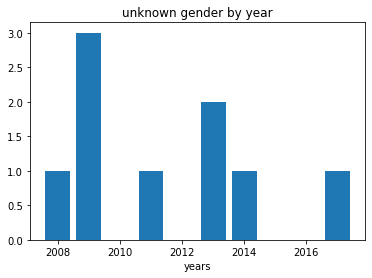

In [34]:
# Importing matplotlib
import matplotlib.pyplot as plt

# This makes plots appear in the notebook
%matplotlib inline

# Plotting the bar chart
plt.bar(years, unknown_by_yr)

# [OPTIONAL] - Setting a title, and axes labels
plt.title('unknown gender by year')
plt.xlabel('years')

## Gender distribution over time
<p>Finally, we use a grouped bar chart to look at the distribution of male and female authors over time.</p>

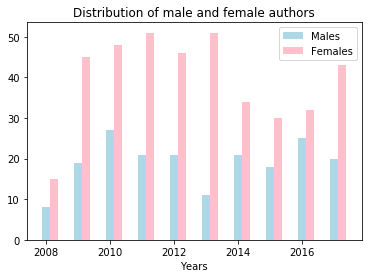

In [35]:
# Creating a new list, where 0.25 is added to each year
years_shifted = [year + 0.25 for year in years]

# Plotting males_by_yr by year
plt.bar(years, males_by_yr, width = 0.25, color = 'lightblue')

# Plotting females_by_yr by years_shifted
plt.bar(years_shifted, females_by_yr, width = 0.25, color = 'pink')

#  relevant Axes labels and Chart Title
plt.title('Distribution of male and female authors')
plt.xlabel('Years')
plt.legend(['Males','Females'])